In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostRegressor
from matplotlib import pyplot
import shap

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from scipy import stats
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import json
pd.set_option('display.max_columns', 1000)

# Objective

* In the last notebook we create our baseline model including a feature selection part. 
* Cohen cappa score of 0.456 (lb) with a local cv score of 0.529
* In this notebook we are going to add more features and remove others that i think they overfitt the train set and then check if our local cv score improve.
* Next, we will check if this improvement aligns with the lb.

# Notes
* Check the distribution of the target variable of the out of folds score and the prediction distribution. A good model should more or less have the same distribution.

In [2]:
def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    dist = Counter(reduce_train['accuracy_group'])
    for k in dist:
        dist[k] /= len(reduce_train)
    reduce_train['accuracy_group'].hist()
    
    acum = 0
    bound = {}
    for i in range(3):
        acum += dist[i]
        bound[i] = np.percentile(y_pred, acum * 100)

    def classify(x):
        if x <= bound[0]:
            return 0
        elif x <= bound[1]:
            return 1
        elif x <= bound[2]:
            return 2
        else:
            return 3
    

    
    y_pred = np.array(list(map(classify, y_pred))).reshape(y_true.shape)

    return 'cappa', cohen_kappa_score(y_true, y_pred, weights='quadratic'), True

In [3]:
def cohenkappa(ypred, y):
    y = y.get_label().astype("int")
    ypred = ypred.reshape((4, -1)).argmax(axis = 0)
    loss = cohenkappascore(y, y_pred, weights = 'quadratic')
    return "cappa", loss, True

In [4]:
def read_data():
    print('Reading train.csv file....')
    train = pd.read_csv('train.csv')
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv('test.csv')
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv('train_labels.csv')
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv('specs.csv')
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv('sample_submission.csv')
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

In [5]:
def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    # make a list with all the unique 'titles' from the train and test set
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    # make a list with all the unique 'event_code' from the train and test set
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    # make a list with all the unique worlds from the train and test set
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    # create a dictionary numerating the titles
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    # replace the text titles with the number titles from the dict
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    # then, it set one element, the 'Bird Measurer (Assessment)' as 4110, 10 more than the rest
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code

In [6]:
train.head()

NameError: name 'train' is not defined

In [7]:
get_data(train[train['installation_id']=='0006a69f'])

NameError: name 'get_data' is not defined

In [8]:
# this is the function that convert the raw data into processed features
def get_data(user_sample, test_set=False):
    '''
    The user_sample is a DataFrame from train or test where the only one 
    installation_id is filtered
    And the test_set parameter is related with the labels processing, that is only requered
    if test_set=False
    '''
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    
    # new features: time spent in each activity
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
        
    # last features
    sessions_count = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
                    
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(last_accuracy_title.copy())
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features['installation_session_count'] = sessions_count
            
            variety_features = [('var_event_code', event_code_count),
                              ('var_event_id', event_id_count),
                               ('var_title', title_count),
                               ('var_title_event_code', title_event_code_count)]
            
            for name, dict_counts in variety_features:
                arr = np.array(list(dict_counts.values()))
                features[name] = np.count_nonzero(arr)
                 
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            features['game_session'] = session['game_session'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
                features['duration_std'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        sessions_count += 1
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

In [9]:
def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    compiled_test_train = []
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_train = get_data(user_sample, test_set = False)
        compiled_test_train += test_train
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    reduce_test_train = pd.DataFrame(compiled_test_train)
    categoricals = ['session_title']
    return reduce_train, reduce_test,reduce_test_train,  categoricals

In [10]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.cv = self.get_cv()
        self.verbose = verbose
        self.params = self.get_params()
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(reduce_train), ))
        y_pred = np.zeros((len(reduce_test), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, eval_qwk_lgb_regr(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = eval_qwk_lgb_regr(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our oof cohen kappa score is: ', loss_score)
        return y_pred, loss_score, model

In [11]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100
                    }
        return params

In [12]:
class Xgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return xgb.train(self.params, train_set, 
                         num_boost_round=5000, evals=[(train_set, 'train'), (val_set, 'val')], 
                         verbose_eval=verbosity, early_stopping_rounds=100)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = xgb.DMatrix(x_train, y_train)
        val_set = xgb.DMatrix(x_val, y_val)
        return train_set, val_set
    
    def convert_x(self, x):
        return xgb.DMatrix(x)
        
    def get_params(self):
        params = {'colsample_bytree': 0.8,                 
            'learning_rate': 0.01,
            'max_depth': 10,
            'subsample': 1,
            'objective':'reg:squarederror',
            #'eval_metric':'rmse',
            'min_child_weight':3,
            'gamma':0.25,
            'n_estimators':5000}

        return params

In [13]:
class Catb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        clf = CatBoostRegressor(**self.params)
        clf.fit(train_set['X'], 
                train_set['y'], 
                eval_set=(val_set['X'], val_set['y']),
                verbose=verbosity, 
                cat_features=self.categoricals)
        return clf
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        params = {'loss_function': 'RMSE',
                   'task_type': "CPU",
                   'iterations': 5000,
                   'od_type': "Iter",
                    'depth': 10,
                  'colsample_bylevel': 0.5, 
                   'early_stopping_rounds': 300,
                    'l2_leaf_reg': 18,
                   'random_seed': 42,
                    'use_best_model': True
                    }
        return params

In [14]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

class Nn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        print(train_df[features].shape)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(train_set['X'].shape[1],)),
            tf.keras.layers.Dense(200, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(100, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(25, activation='relu'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation='relu')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [15]:
from random import choice

class Cnn_Model(Base_Model):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True):
        features = features.copy()
        if len(categoricals) > 0:
            for cat in categoricals:
                enc = OneHotEncoder()
                train_cats = enc.fit_transform(train_df[[cat]])
                test_cats = enc.transform(test_df[[cat]])
                cat_cols = ['{}_{}'.format(cat, str(col)) for col in enc.active_features_]
                features += cat_cols
                train_cats = pd.DataFrame(train_cats.toarray(), columns=cat_cols)
                test_cats = pd.DataFrame(test_cats.toarray(), columns=cat_cols)
                train_df = pd.concat([train_df, train_cats], axis=1)
                test_df = pd.concat([test_df, test_cats], axis=1)
        scalar = MinMaxScaler()
        train_df[features] = scalar.fit_transform(train_df[features])
        test_df[features] = scalar.transform(test_df[features])
        self.create_feat_2d(features)
        super().__init__(train_df, test_df, features, categoricals, n_splits, verbose)
        
    def create_feat_2d(self, features, n_feats_repeat=50):
        self.n_feats = len(features)
        self.n_feats_repeat = n_feats_repeat
        self.mask = np.zeros((self.n_feats_repeat, self.n_feats), dtype=np.int32)
        for i in range(self.n_feats_repeat):
            l = list(range(self.n_feats))
            for j in range(self.n_feats):
                c = l.pop(choice(range(len(l))))
                self.mask[i, j] = c
        self.mask = tf.convert_to_tensor(self.mask)
        print(self.mask.shape)
       
        
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0

        inp = tf.keras.layers.Input(shape=(self.n_feats))
        x = tf.keras.layers.Lambda(lambda x: tf.gather(x, self.mask, axis=1))(inp)
        x = tf.keras.layers.Reshape((self.n_feats_repeat, self.n_feats, 1))(x)
        x = tf.keras.layers.Conv2D(18, (50, 50), strides=50, activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        #x = tf.keras.layers.Dense(200, activation='relu')(x)
        #x = tf.keras.layers.LayerNormalization()(x)
        #x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(100, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(50, activation='relu')(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        out = tf.keras.layers.Dense(1)(x)
        
        model = tf.keras.Model(inp, out)
    
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
        print(model.summary())
        save_best = tf.keras.callbacks.ModelCheckpoint('nn_model.w8', save_weights_only=True, save_best_only=True, verbose=1)
        early_stop = tf.keras.callbacks.EarlyStopping(patience=20)
        model.fit(train_set['X'], 
                train_set['y'], 
                validation_data=(val_set['X'], val_set['y']),
                epochs=100,
                 callbacks=[save_best, early_stop])
        model.load_weights('nn_model.w8')
        return model
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = {'X': x_train, 'y': y_train}
        val_set = {'X': x_val, 'y': y_val}
        return train_set, val_set
        
    def get_params(self):
        return None

In [ ]:
# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code = encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, reduce_test_train, categoricals = get_train_and_test(train, test)

In [ ]:
save((reduce_train, reduce_test, reduce_test_train, categoricals), 'to_reg_data')

In [ ]:
reduce_test_train.head()

In [16]:
import _pickle as pickle
def save(file,name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'wb')
    else:
        outfile = open(name+'.pickle', 'wb')
    pickle.dump(file, outfile)
    outfile.close
    
def load(name, folder = ""):
    if folder != "":
        outfile = open('./'+folder+'/'+name+'.pickle', 'rb')
    else:
        outfile = open(name+'.pickle', 'rb')
    file = pickle.load(outfile)
    outfile.close
    return file

In [23]:
reduce_train = load('smart train dataset')
dtitle = load('dico_title')
reduce_train = reduce_train.replace({'pred_title': dtitle})
reduce_train = reduce_train.fillna(-2)

reduce_test = load('smart test dataset')
dtitle = load('dico_title')
reduce_test = reduce_test.replace({'pred_title': dtitle})
reduce_test = reduce_test.fillna(-2)

reduce_train = reduce_train.astype('float64')
reduce_test = reduce_test.astype('float64')

categoricals = ['pred_title']

In [18]:
reduce_train.head()

,pred_title,poids_n_clips,poids_time_inst_mean,poids_time_inst_sum,poids_n_activity,poids_act_start_round_mean,poids_act_start_round_sum,poids_activity_action_mean,poids_activity_action_sum,poids_n_game,poids_game_start_round_mean,poids_game_start_round_sum,poids_game_action_mean,poids_game_action_sum,poids_game_mean_acc,poids_game_min_acc,poids_game_max_acc,poids_n_assessment,poids_assessment_start_round_mean,poids_assessment_start_round_sum,poids_assessment_action_mean,poids_assessment_action_sum,poids_assessment_mean_acc,poids_assessment_min_acc,poids_assessment_max_acc,poids_assessment_first_acc,poids_assessment_last_acc,poids_assessment_first_acc_group,poids_assessment_last_acc_group,taille_n_clips,taille_time_inst_mean,taille_time_inst_sum,taille_n_activity,taille_act_start_round_mean,taille_act_start_round_sum,taille_activity_action_mean,taille_activity_action_sum,taille_n_game,taille_game_start_round_mean,taille_game_start_round_sum,taille_game_action_mean,taille_game_action_sum,taille_game_mean_acc,taille_game_min_acc,taille_game_max_acc,taille_n_assessment,taille_assessment_start_round_mean,taille_assessment_start_round_sum,taille_assessment_action_mean,taille_assessment_action_sum,taille_assessment_mean_acc,taille_assessment_min_acc,taille_assessment_max_acc,taille_assessment_first_acc,taille_assessment_last_acc,taille_assessment_first_acc_group,taille_assessment_last_acc_group,volume_n_clips,volume_time_inst_mean,volume_time_inst_sum,volume_n_activity,volume_act_start_round_mean,volume_act_start_round_sum,volume_activity_action_mean,volume_activity_action_sum,volume_n_game,volume_game_start_round_mean,volume_game_start_round_sum,volume_game_action_mean,volume_game_action_sum,volume_game_mean_acc,volume_game_min_acc,volume_game_max_acc,volume_n_assessment,volume_assessment_start_round_mean,volume_assessment_start_round_sum,volume_assessment_action_mean,volume_assessment_action_sum,volume_assessment_mean_acc,volume_assessment_min_acc,volume_assessment_max_acc,volume_assessment_first_acc,volume_assessment_last_acc,volume_assessment_first_acc_group,volume_assessment_last_acc_group,matcher_n_clips,matcher_time_inst_mean,matcher_time_inst_sum,matcher_n_activity,matcher_act_start_round_mean,matcher_act_start_round_sum,matcher_activity_action_mean,matcher_activity_action_sum,matcher_n_game,matcher_game_start_round_mean,matcher_game_start_round_sum,matcher_game_action_mean,matcher_game_action_sum,matcher_game_mean_acc,matcher_game_min_acc,matcher_game_max_acc,matcher_n_assessment,matcher_assessment_start_round_mean,matcher_assessment_start_round_sum,matcher_assessment_action_mean,matcher_assessment_action_sum,matcher_assessment_mean_acc,matcher_assessment_min_acc,matcher_assessment_max_acc,matcher_assessment_first_acc,matcher_assessment_last_acc,matcher_assessment_first_acc_group,matcher_assessment_last_acc_group,trier_n_clips,trier_time_inst_mean,trier_time_inst_sum,trier_n_activity,trier_act_start_round_mean,trier_act_start_round_sum,trier_activity_action_mean,trier_activity_action_sum,trier_n_game,trier_game_start_round_mean,trier_game_start_round_sum,trier_game_action_mean,trier_game_action_sum,trier_game_mean_acc,trier_game_min_acc,trier_game_max_acc,trier_n_assessment,trier_assessment_start_round_mean,trier_assessment_start_round_sum,trier_assessment_action_mean,trier_assessment_action_sum,trier_assessment_mean_acc,trier_assessment_min_acc,trier_assessment_max_acc,trier_assessment_first_acc,trier_assessment_last_acc,trier_assessment_first_acc_group,trier_assessment_last_acc_group,mesurer_n_clips,mesurer_time_inst_mean,mesurer_time_inst_sum,mesurer_n_activity,mesurer_act_start_round_mean,mesurer_act_start_round_sum,mesurer_activity_action_mean,mesurer_activity_action_sum,mesurer_n_game,mesurer_game_start_round_mean,mesurer_game_start_round_sum,mesurer_game_action_mean,mesurer_game_action_sum,mesurer_game_mean_acc,mesurer_game_min_acc,mesurer_game_max_acc,mesurer_n_assessment,mesurer_assessment_start_round_mean,mesurer_

0.002975231990911401


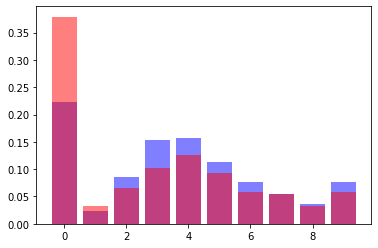

0.002975231990911401

In [25]:
def stract_hists(feature, train=reduce_train, test=reduce_test, adjust=False, plot=False):
    n_bins = 10
    train_data = train[feature]
    test_data = test[feature]
    if adjust:
        test_data *= train_data.mean() / test_data.mean()
    perc_90 = np.percentile(train_data, 95)
    train_data = np.clip(train_data, 0, perc_90)
    test_data = np.clip(test_data, 0, perc_90)
    train_hist = np.histogram(train_data, bins=n_bins)[0] / len(train_data)
    test_hist = np.histogram(test_data, bins=n_bins)[0] / len(test_data)
    msre = mean_squared_error(train_hist, test_hist)
    if plot:
        print(msre)
        plt.bar(range(n_bins), train_hist, color='blue', alpha=0.5)
        plt.bar(range(n_bins), test_hist, color='red', alpha=0.5)
        plt.show()
    return msre
stract_hists('poids_time_inst_mean', adjust=False, plot=True)

In [ ]:
reduce_train.head()

In [ ]:
reduce_train.head()

In [24]:
# call feature engineering function
features = reduce_train.loc[(reduce_train.sum(axis=1) != 0), (reduce_train.sum(axis=0) != 0)].columns # delete useless columns
features = [x for x in features if x not in ['accuracy_group', 'installation_id']]

In [26]:
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(reduce_train[feat_a], reduce_train[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

invalid value encountered in true_divide
invalid value encountered in true_divide


1: FEAT_A: poids_act_start_round_sum FEAT_B: matcher_act_start_round_sum - Correlation: 1.0
2: FEAT_A: poids_act_start_round_sum FEAT_B: mesurer_act_start_round_sum - Correlation: 1.0
3: FEAT_A: poids_n_assessment FEAT_B: poids_assessment_start_round_sum - Correlation: 0.9999952028311985
4: FEAT_A: taille_n_clips FEAT_B: mesurer_n_clips - Correlation: 1.0
5: FEAT_A: trier_game_mean_acc FEAT_B: trier_game_min_acc - Correlation: 0.9951611824826374
6: FEAT_A: trier_game_mean_acc FEAT_B: trier_game_max_acc - Correlation: 0.9965058856737266


In [27]:
to_exclude = [] 
ajusted_test = reduce_test.copy()
for feature in ajusted_test.columns:
    if feature not in ['pred_title','accuracy_group', 'installation_id', 'accuracy_group', 'session_title']:
        data = reduce_train[feature]
        train_mean = data.mean()
        data = ajusted_test[feature] 
        test_mean = data.mean()
        try:
            error = stract_hists(feature, adjust=True)
            ajust_factor = train_mean / test_mean
            if ajust_factor > 10 or ajust_factor < 0.1:# or error > 0.01:
                to_exclude.append(feature)
                print(feature, train_mean, test_mean, error)
            else:
                ajusted_test[feature] *= ajust_factor
        except:
            to_exclude.append(feature)
            print(feature, train_mean, test_mean)

poids_assessment_first_acc_group 0.26834488381573585 -0.611 0.01749954105396705
poids_assessment_last_acc_group 0.012994292702812882 -0.779 0.028457937554736756
taille_act_start_round_sum 0.0 0.0
taille_game_mean_acc -0.017374282294808193 -0.4047999387413136 0.002439364481838674
taille_game_max_acc 0.1423376266721536 -0.30963490067823324 0.0117430862341328
taille_assessment_start_round_mean 0.4156633918568049 -0.40848159735626777 0.02764427882262358
taille_assessment_max_acc -0.0022027695291302685 -0.7252488095238097 0.011552974182681705
taille_assessment_first_acc_group 0.8089074602527517 -0.132 0.0037027082996452347
taille_assessment_last_acc_group 0.6978699551569507 -0.185 0.0060699524198012745
volume_n_clips 0.0 0.0
volume_game_start_round_mean 0.9878834213216418 0.06570890173045345 0.017917666066211094
volume_assessment_start_round_mean 0.02980054269810133 -0.8332465367965368 0.013495393314375482
volume_assessment_first_acc_group 0.22426620464737057 -0.729 0.020516364839546043
vol

In [28]:
features = [x for x in features if x not in (to_exclude + to_remove)]
reduce_train[features].shape

(19624, 137)

In [ ]:
save(features, 'huge features')

In [ ]:
features

In [29]:
labels = pd.read_csv('train_labels.csv')
test_labels = load('test labels')
Y = np.concatenate([labels['accuracy_group'].values.astype('float64'), test_labels['accuracy_group'].values.astype('float64')], axis = 0)

reduce_train['accuracy_group'] = Y

Found `n_estimators` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.03523	valid_1's rmse: 1.05309
[200]	training's rmse: 0.971703	valid_1's rmse: 1.00743
[300]	training's rmse: 0.942678	valid_1's rmse: 0.995398
[400]	training's rmse: 0.922711	valid_1's rmse: 0.990913
[500]	training's rmse: 0.906398	valid_1's rmse: 0.988497
[600]	training's rmse: 0.892286	valid_1's rmse: 0.987719
[700]	training's rmse: 0.879494	valid_1's rmse: 0.987136
[800]	training's rmse: 0.867436	valid_1's rmse: 0.987042
Early stopping, best iteration is:
[731]	training's rmse: 0.875691	valid_1's rmse: 0.986779
Partial score of fold 0 is: 0.583567857881254
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.0361	valid_1's rmse: 1.0491
[200]	training's rmse: 0.973078	valid_1's rmse: 1.00288
[300]	training's rmse: 0.943722	valid_1's rmse: 0.990195
[400]	training's rmse: 0.923537	valid_1's rmse: 0.985562
[500]	training's rmse: 0.907217	valid_1's rmse: 0.983549
[600]

Series.base is deprecated and will be removed in a future version


[0]	train-rmse:1.86406	val-rmse:1.86515
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.02399	val-rmse:1.16901
[200]	train-rmse:0.746215	val-rmse:1.02608
[300]	train-rmse:0.629724	val-rmse:1.00136
[400]	train-rmse:0.572178	val-rmse:0.998964
[500]	train-rmse:0.54261	val-rmse:0.999874
Stopping. Best iteration:
[401]	train-rmse:0.571973	val-rmse:0.998944

Partial score of fold 0 is: 0.5684755867081347
[0]	train-rmse:1.86408	val-rmse:1.86517
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:1.02309	val-rmse:1.16232
[200]	train-rmse:0.743614	val-rmse:1.01564
[300]	train-rmse:0.629754	val-rmse:0.99329
[400]	train-rmse:0.573786	val-rmse:0.991684
Stopping. Best iteration:
[381]	train-rmse:0.581128	val-rmse:0.991441

Partial score of fold 1 is: 0.5836082301606775
[0]	train-rms

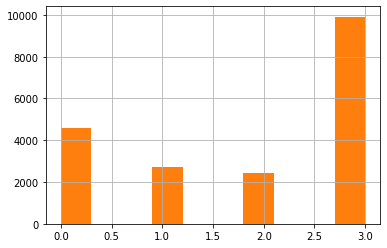

In [31]:
#cat_model = Catb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
xgb_model = Xgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals)

In [ ]:
categoricals

In [ ]:
#cnn_model = Cnn_Model(reduce_train, ajusted_test, features, categoricals=categoricals)
nn_model = Nn_Model(reduce_train, ajusted_test, features, categoricals=[])

In [32]:
weights = {'lbg': 0.80, 'cat': 0, 'xgb': 0.20, 'nn': 0.20}

final_pred = (lgb_model.y_pred * weights['lbg']) + (xgb_model.y_pred * weights['xgb'])
#final_pred = cnn_model.y_pred
print(final_pred.shape)

(1000,)


In [ ]:
dir(lgb_model.model)

In [ ]:
lgb_model.model.feature_importance()

In [ ]:
lgb_model.model.feature_name()

In [ ]:
plt.rcParams["figure.figsize"] = (25,10)
ind0 = 900
ind1 = 1000
plt.plot(lgb_model.model.feature_name()[ind0:ind1], lgb_model.model.feature_importance()[ind0:ind1])
plt.xticks(lgb_model.model.feature_name()[ind0:ind1], lgb_model.model.feature_name()[ind0:ind1], rotation = 'vertical')
plt.savefig('features.png')

In [ ]:
l = []
for i in range(len(lgb_model.model.feature_name())):
    l.append([lgb_model.model.feature_importance()[i], lgb_model.model.feature_name()[i]])
l.sort(reverse = True)
l = np.array(l)
list(l)

In [ ]:
p = 50
feats_to_keep = l[l[:,0].astype('float64') > p,1]
l[l[:,0].astype('float64') > p,0].astype('float64').sum()


In [ ]:
feats_to_keep.shape

In [ ]:
feats_to_keep

In [ ]:
reduce_train['Sandcastle Builder (Activity)_time_instruction']
Sandcastle_Builder_(Activity)_time_instruction

In [ ]:
list(reduce_train.columns)

In [ ]:
len(lgb_model.model.feature_name())

In [ ]:
from copy import deepcopy
reduce_train1 = reduce_train[features + ['accuracy_group']]
ajusted_test1 = ajusted_test[features+ ['accuracy_group']]

reduce_train1.columns = lgb_model.model.feature_name()+ ['accuracy_group']
ajusted_test1.columns = lgb_model.model.feature_name()+ ['accuracy_group']

lgb_model = Lgb_Model(reduce_train1, ajusted_test1, feats_to_keep, categoricals=categoricals)
xgb_model = Xgb_Model(reduce_train1, ajusted_test1, feats_to_keep, categoricals=categoricals)

In [ ]:
#pd.DataFrame([(round(a, 2), round(b, 2), round(c, 2), round(d, 2)) for a, b, c, d in zip(lgb_model.y_pred, cat_model.y_pred, xgb_model.y_pred, nn_model.y_pred)], columns=['lgb', 'cat', 'xgb', 'nn']).head(50)

{0: 0.8496178775991476, 1: 1.3927782019296213, 2: 1.6429836844573606}


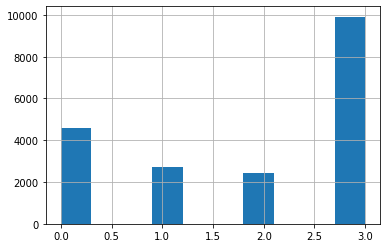

In [33]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
reduce_train['accuracy_group'].hist()

acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(final_pred, acum * 100)
print(bound)

def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
final_pred = np.array(list(map(classify, final_pred)))

ids, game_inst = load('test_labels')
X = []
for i in range(len(final_pred)):
    X.append([ids[i], final_pred[i]])
    
pred = pd.DataFrame(X, columns = ['installation_id','accuracy_group'])
pred.index = pred['installation_id']

sample_sub = pd.read_csv('sample_submission_exemple.csv')
sample_sub['accuracy_group'] = pred.loc[sample_sub['installation_id'].values]['accuracy_group'].values

sample_sub.to_csv('submission1.csv', index = False)